# Notebook 1 : accidents_prediction.ipynb

## Prédiction de la probabilité d’accident (Faible / Moyenne / Forte)


1. Imports  
2. Chargement des données  
3. Sélection des données  
4. Création de la variable cible (ACCIDENT_RISK)  
5. Séparation X / y  
6. Prétraitement  
7. Modèle Random Forest  
&nbsp;&nbsp;&nbsp;7.1. Entraînement  
&nbsp;&nbsp;&nbsp;7.2. Évaluation  
&nbsp;&nbsp;&nbsp;7.3. Prédiction 
8. Logistic Regression  
9. XGBoost  
&nbsp;&nbsp;&nbsp;9.1. Matrice de Confusion XGBoost  
10. Comparaison visuelle

### 1. Imports

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix

### 2. Chargement des données

In [8]:
df = pd.read_csv("../data/crushes.csv")
df.head()

C:\Users\ISMAIL\AppData\Local\Temp\ipykernel_15724\3805320807.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/crushes.csv")


,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,a15266915379e2ee2439548d7460f29d185a18f97e4bdd...,Y,12/07/2025 03:40:00 AM,45,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN BARRIER,...,0.0,0.0,2.0,0.0,3,1,12,41.818752,-87.596109,POINT (-87.59610943105 41.818751815122)
1,6bb856cb0a365fc01d387327d110f5f31db3d37014b94e...,NaN,12/07/2025 03:20:00 AM,30,NO CONTROLS,NO CONTROLS,SNOW,DARKNESS,PARKED MOTOR VEHICLE,ONE-WAY,...,0.0,0.0,1.0,0.0,3,1,12,41.895313,-87.722261,POINT (-87.722261203591 41.895313086294)
2,2c14cdf8733affd2dcb740f61b1ccfa91b526d2d3027aa...,NaN,12/07/2025 03:15:00 AM,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,...,NaN,NaN,NaN,NaN,3,1,12,41.816047,-87.606548,POINT (-87.606547971177 41.816046839974)
3,152896ecb53957ff5a8435680bf30a2c3ca91c9ce3fda8...,NaN,12/07/2025 03:00:00 AM,20,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,0.0,0.0,2.0,0.0,3,1,12,41.959199,-87.730923,POINT (-87.730923030587 41.959199363355)
4,f90d380de5e8821f520eb2d631644d6a121711709833ca...,NaN,12/07/2025 02:15:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,...,0.0,0.0,1.0,0.0,2,1,12,41.895665,-87.706411,POINT (-87.706411477325 41.895664552516)


### 3. Sélection des colonnes utiles

In [9]:
features = [
    "CRASH_HOUR",
    "CRASH_DAY_OF_WEEK",
    "CRASH_MONTH",
    "WEATHER_CONDITION",
    "LIGHTING_CONDITION",
    "ROADWAY_SURFACE_COND",
    "TRAFFIC_CONTROL_DEVICE",
    "TRAFFICWAY_TYPE",
    "LATITUDE",
    "LONGITUDE"
]

target_cols = [
    "MOST_SEVERE_INJURY",
    "INJURIES_TOTAL",
    "CRASH_TYPE",
    "INJURIES_FATAL"
]

df = df[features + target_cols]
df = df.dropna()


### 4. Création de la variable cible (ACCIDENT_RISK)

In [10]:
def accident_risk(row):
    if row["INJURIES_FATAL"] > 0 or row["MOST_SEVERE_INJURY"] in ["FATAL", "INCAPACITATING INJURY"]:
        return "Forte"
    elif row["INJURIES_TOTAL"] > 0 or "INJURY" in str(row["CRASH_TYPE"]):
        return "Moyenne"
    else:
        return "Faible"

df["ACCIDENT_RISK"] = df.apply(accident_risk, axis=1)

### 5. Séparation X / y

In [11]:
X = df[features]
y = df["ACCIDENT_RISK"]

### 6. Prétraitement

In [12]:
categorical_features = [
    "WEATHER_CONDITION",
    "LIGHTING_CONDITION",
    "ROADWAY_SURFACE_COND",
    "TRAFFIC_CONTROL_DEVICE",
    "TRAFFICWAY_TYPE"
]

numerical_features = [
    "CRASH_HOUR",
    "CRASH_DAY_OF_WEEK",
    "CRASH_MONTH",
    "LATITUDE",
    "LONGITUDE"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)


### 7. Modèle Random Forest

In [13]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", model)
])


7.1. Entraînement

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


7.2. Évaluation

c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

              precision    recall  f1-score   support

       Forte       0.00      0.00      0.00      3498
     Moyenne       0.98      1.00      0.99    196283

    accuracy                           0.98    199781
   macro avg       0.49      0.50      0.50    199781
weighted avg       0.97      0.98      0.97    199781



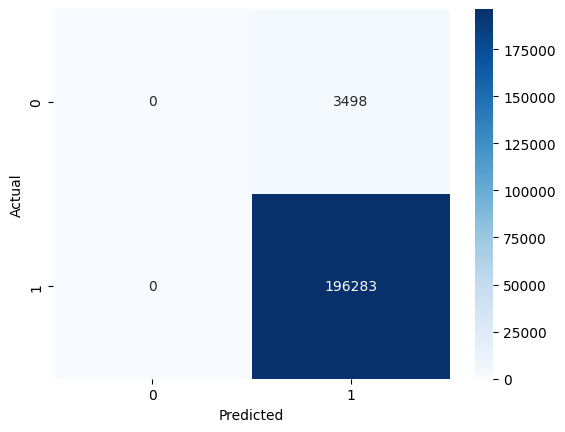

In [15]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

7.3. Prédiction

In [16]:
sample = X.iloc[[0]]
pipeline.predict(sample)

array(['Moyenne'], dtype=object)

### 8. Logistic Regression

In [17]:
log_reg = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    n_jobs=-1
)

pipeline_logreg = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", log_reg)
])

pipeline_logreg.fit(X_train, y_train)

y_pred_logreg = pipeline_logreg.predict(X_test)

print("===== Logistic Regression =====")
print(classification_report(y_test, y_pred_logreg))


c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


===== Logistic Regression =====


c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

       Forte       0.00      0.00      0.00      3498
     Moyenne       0.98      1.00      0.99    196283

    accuracy                           0.98    199781
   macro avg       0.49      0.50      0.50    199781
weighted avg       0.97      0.98      0.97    199781



c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### 9. XGBoost

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes :", label_encoder.classes_)


Classes : ['Forte' 'Moyenne']


In [19]:
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [20]:
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)

pipeline_xgb = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", xgb_model)
])

pipeline_xgb.fit(X_train, y_train_enc)

y_pred_xgb_enc = pipeline_xgb.predict(X_test)

# Décodage vers labels texte
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_enc)
y_test_decoded = label_encoder.inverse_transform(y_test_enc)

print("===== XGBoost =====")
print(classification_report(y_test_decoded, y_pred_xgb))


===== XGBoost =====


c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

       Forte       0.00      0.00      0.00      3498
     Moyenne       0.98      1.00      0.99    196283

    accuracy                           0.98    199781
   macro avg       0.49      0.50      0.50    199781
weighted avg       0.97      0.98      0.97    199781



c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ISMAIL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


9.1. Matrice de Confusion XGBoost

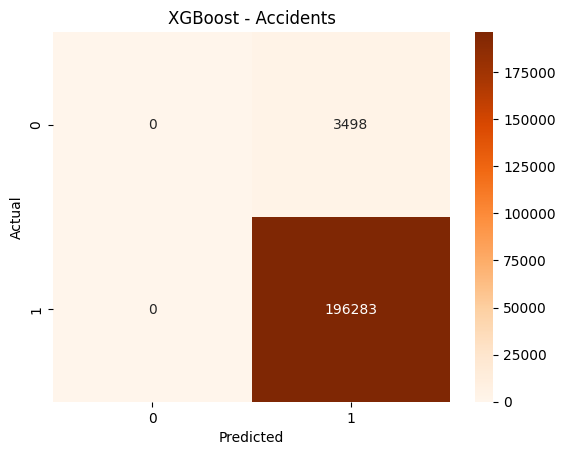

In [21]:
cm = confusion_matrix(y_test_decoded, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("XGBoost - Accidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 10. Comparaison visuelle


Random Forest


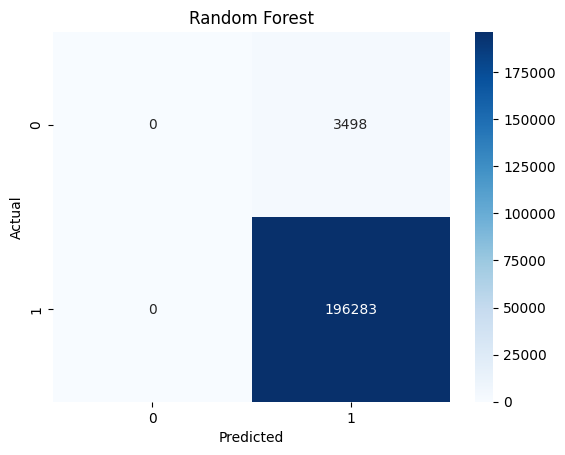


Logistic Regression


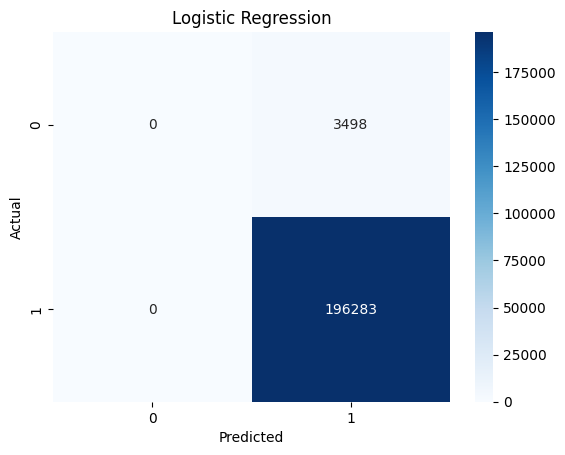


XGBoost


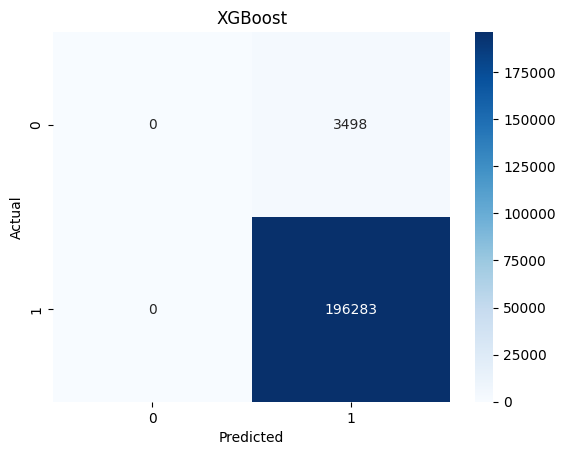

In [22]:
models_preds = {
    "Random Forest": pipeline.predict(X_test),
    "Logistic Regression": y_pred_logreg,
    "XGBoost": y_pred_xgb
}

for name, preds in models_preds.items():
    print(f"\n{name}")
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
